# Gated Recurrent Units (GRU)

As RNNs and particularly the LSTM architecture rapidly gained popularity during the 2010s, a number of papers began to experiment with simplified architectures in hopes of retaining the key idea of incorporating an internal state and multiplicative gating mechanisms but with the aim of speeding up computation. The gated recurrent unit (GRU) [Cho et al., 2014](https://arxiv.org/abs/1409.1259) offered a streamlined version of the LSTM memory cell that often achieves comparable performance but with the advantage of being faster to compute [Chung et al., 2014](https://arxiv.org/abs/1412.3555).

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from scratch

We instantiate all weights and biases relating to the update gate, the reset gate, and the candidate hidden state.

In [4]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

### Model

In [5]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

## Training

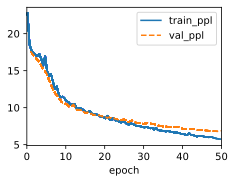

In [6]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Concise implementation

In [7]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

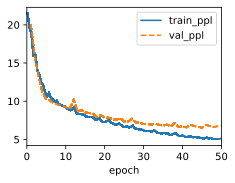

In [8]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

### Prediction

In [9]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and seatiention is '

### Summary: 

Compared with LSTMs, GRUs achieve similar performance but tend to be lighter computationally. Generally, compared with simple RNNs, gated RNNs like LSTMs and GRUs can better capture dependencies for sequences with large time step distances. GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.